In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import datetime 
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/data_cmip6_LR/core/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#_____________________________________________________________________________________
# set datapath
input_paths= list()
input_paths.append('/albedo/work/user/pscholz/data_cmip6_LR/')

input_names   = list()
input_names.append('piControl')

#_____________________________________________________________________________________
# set run infos
which_model= 'AWI-ESM-1-1-LR'
which_run  = 'piControl'
which_enmem= 'r1i1p1f1'
vname      = 'amoc'  # gmoc, amoc, ipmoc, imoc, pmoc
year       = [1855, 1954]
dyr        = 10

mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True
do_netcdf         = True
do_info           = True

In [21]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    
#     # disable dask worker heartbeat --> prevent error ?
#     from dask import config as cfg
#     cfg.set({'distributed.scheduler.worker-ttl': None})
    
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

 --> memory_limit: 4.167 GB


## > Load mesh:

In [22]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False, do_f14cmip6=True)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

#______________________________________________________________________________________________________        
if save_path is not None:
    if not os.path.isdir(save_path): os.makedirs(save_path)

#______________________________________________________________________________________________________
chunks ={'time'   :'auto', 
         'nod2'   :'auto', 
         'elem'   :'auto', 
         'ncells' :'auto', 
         'ntriags':'auto', }   

# create list with starting years of loaded cmip6 netcdf files
yr_cs   = np.around(year[0], decimals=-np.log10(np.float32(dyr)))
yr_ce   = np.around(year[1], decimals=-np.log10(np.float32(dyr)))
yr_list = np.unique(np.hstack(( year[0], np.arange(yr_cs+1, yr_ce+2, dyr), year[1]+1 )))

 > load mesh from *.out files: /albedo/work/user/pscholz/data_cmip6_LR/core
 --> you are in fesom1.4 mode, no nlvls information!
 --> you are in fesom1.4 mode, no elvls information!
 > comp e_area
 > load n_area from griddes.nc
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/data_cmip6_LR/core/tripyview_fesom2_core_pbnd.shp
 > augment lsmask
 > save *.shp to /albedo/work/user/pscholz/data_cmip6_LR/core/tripyview_fesom2_core_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/data_cmip6_LR/core
 > id              = core
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126859
 > #elem           = 244660
 > #lvls           = 46
___________________________________________


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  result = getattr(asarray(obj), method)(*args, **kwds)


##  > Compute: MOC vs. time
- compute annual mean MOC from monthly mean FESOM1.4 AWI-CM-1-1-HR CMIP6 vertical velocities (var:wo)

In [23]:
#______________________________________________________________________________________________________
ts     = clock.time()
zmoc_t = xr.Dataset()
for jj, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath)

    #__________________________________________________________________________________________________
    # loop over year to open 10-year bundled files 
    t1s = clock.time()
    for ii, yr in enumerate(yr_list[:-1]):
        #______________________________________________________________________________________________
        # create cmip6 filename path
        fname       = f'wo_Omon_{which_model}_{which_run}_{which_enmem}_gn_{yr}01-{yr_list[ii+1]-1}12.nc'
        filepath    = os.path.join(datapath, fname)
        print(' --> open file:', filepath)
        
        #______________________________________________________________________________________________
        # load cmip6 filename path
        data = tpv.load_data_fesom2(mesh, filepath, do_filename=True, do_f14cmip6=True, do_tarithm=None, do_zarithm=None,
                                vname='wo', year=year, mon=mon, day=day, record=record, chunks=chunks,
                                depth=depth, descript=descript, do_info=False, do_parallel=do_parallel, do_persist=False).rename({'wo':'w'})
        
        #______________________________________________________________________________________________
        # compute time mean --> data are monthly mean, AMOC usually computed on annual mean
        if do_info: print('     --> compute annual time mean')
        data = data.groupby('time.year').mean('time')
        
        # recreate time axes based on year
        data = data.rename_dims({'year':'time'})
        if yr in data.year.values:
            data = data.assign_coords(time=('time', [datetime.datetime(np.int32(yr), 1, 1) for yr in data.year] )).drop_vars('year')
        else:
            raise ValueError('--> the years you want load can not be found in the time axis of your file. Something is not OK with the data! Check on them!!!')
        
        if do_info: print('     --> xr.compute() ... load everything into memory. This can take a bit!')
        data = data.compute()
        data['w'].attrs['descript']  = f'{which_run}'
        data['w'].attrs['str_ltim']  = f''
        data['w'].attrs['str_lsave'] = f''
        
        #______________________________________________________________________________________________
        # compute zmoc    
        if do_info: print('     --> compute: ', vname)
        zmoc = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=do_info, do_checkbasin=False, do_onelem=False, diagpath=False, 
                             do_load=True, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        del(data)
        
        #______________________________________________________________________________________________
        # accumulate to zmoc over time
        zmoc_t = xr.merge([zmoc_t, zmoc], combine_attrs='drop_conflicts') #no_conflicts
        del(zmoc)
        
        #______________________________________________________________________________________________
        t1e = clock.time()
        print('     --> elapsed time/file:', t1e-t1s, ' sec')
        t1s = t1e
        print('\n')
    
    #__________________________________________________________________________________________________
    # save to netcdf
    if do_netcdf and save_path is not None:
        auxtime   = zmoc_t['time.year'].values
        sfname    = f'{vname}_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
        # sfilepath = os.path.join(datapath, sfname)
        sfilepath = os.path.join(save_path, sfname)
        print(' --> save zmoc_t to file:', sfname)
        zmoc_t.to_netcdf(path=sfilepath, mode='w')
    
print(' --> tot. elapsed time:', clock.time()-ts, ' sec')

/albedo/work/user/pscholz/data_cmip6_LR/
 --> open file: /albedo/work/user/pscholz/data_cmip6_LR/wo_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-186012.nc
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:4.472 s
     --> elapsed time/file: 10.452210187911987  sec


 --> open file: /albedo/work/user/pscholz/data_cmip6_LR/wo_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_186101-187012.nc
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____

 ___parallel loop over longitudinal bins____
 --> do cumsum over latitudes
 --> total time:0.902 s
     --> elapsed time/file: 9.257109642028809  sec


 --> open file: 

##  > Plot: mean MOC 

--> histo: cmin, cmax =  -0.9758027791976929 21.51025390625
{'cstr': 'blue2red', 'cnum': 15, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -0.98, 'cmax': 21.51, 'cmap': <matplotlib.colors.ListedColormap object at 0x1550ca2d8700>, 'clevel': array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]), 'clab': array([ 0.,  3.,  6.,  9., 12., 15., 18., 21.])}


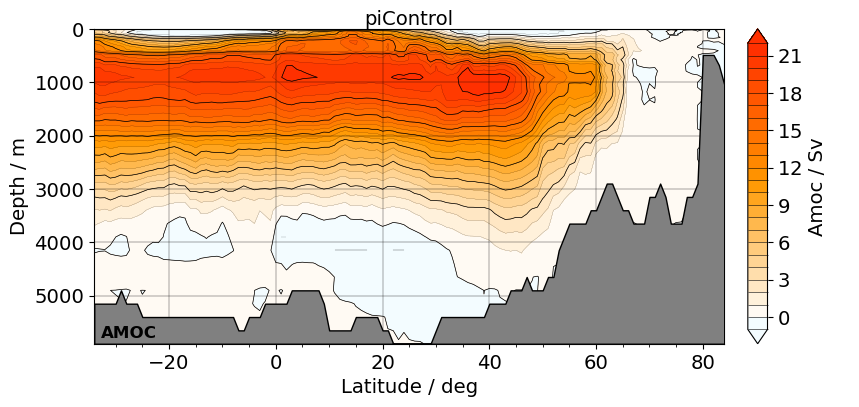

In [27]:
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
auxtime= zmoc_t['time.year'].values
slabel = f'y{auxtime[0]}-{auxtime[-1]}'
nrow0, ncol0= 1,1

if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, which_model, which_run ,slabel, sfmt)) )
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, [zmoc_t.mean(dim='time', keep_attrs=True)], nrow=nrow0, ncol=ncol0, cinfo=cinfo0, 
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                    do_save=sfpath, save_dpi=save_dpi )    

## > Compute: MOC time series @ latitude

In [28]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # depth range definition for upper/lower cell

#____________________________________________________________________________________________________
# compute time-series
if  vname == 'ipmoc' or vname == 'pmoc':
    zmoc_maxatlat = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
elif vname == 'amoc' or vname == 'aamoc':
    zmoc_ucell  = zmoc_t.where((zmoc_t['depth']>=zdefuc[0]) & (zmoc_t['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_ucell'})
    zmoc_lcell  = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
    zmoc_maxatlat = xr.merge([zmoc_ucell, zmoc_lcell], compat='minimal' )
    del(zmoc_ucell, zmoc_lcell)

#_____________________________________________________________________________________________________
# save to netcdf
if (do_netcdf) and (save_path is not None) and (vname in ['amoc', 'aamoc', 'ipmoc', 'pmoc']):
    auxtime   = zmoc_t['time.year'].values
    sfname    = f'{vname}_at_lat_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
    sfilepath = os.path.join(save_path, sfname)
    print(' --> save max. zmoc_t @ lat. to file:', sfname)
    zmoc_maxatlat.to_netcdf(path=sfilepath, mode='w')        

## > Plot: MOC time-series @ latitude

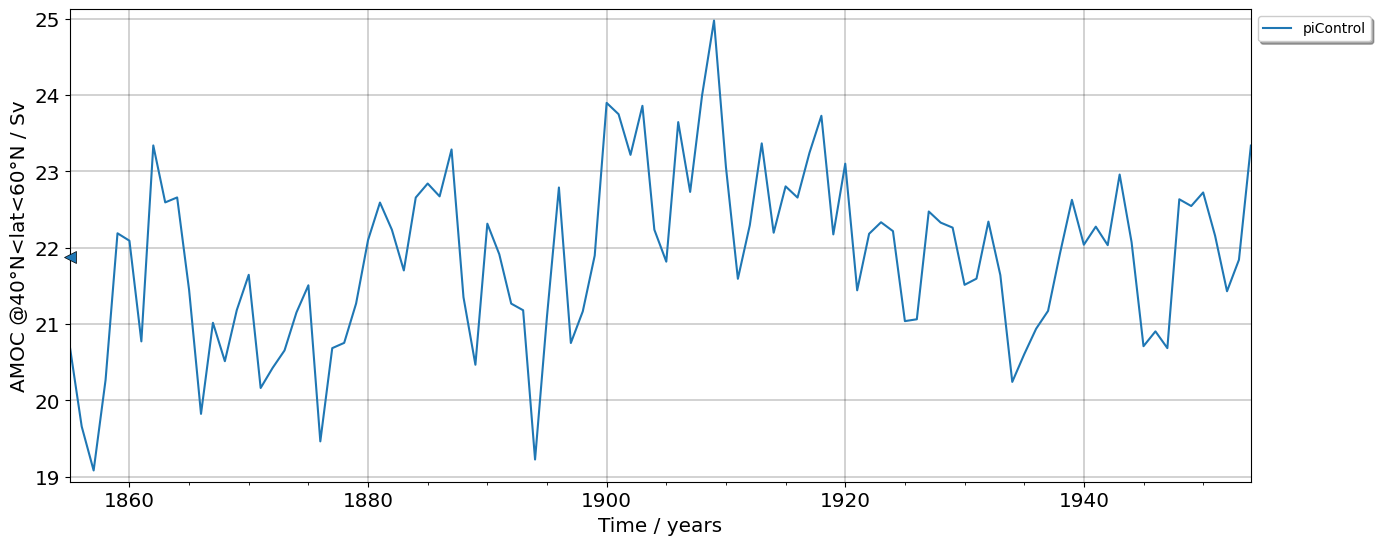

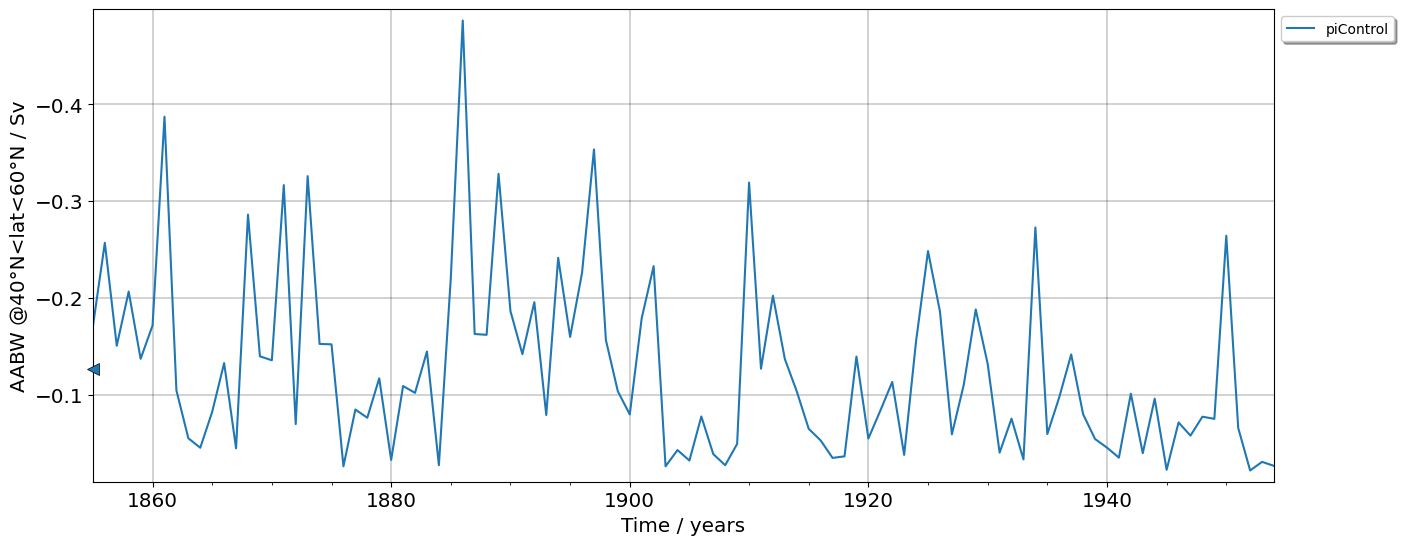

In [31]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
which_lat = ['max'] # 'max' # 'max', 26.0

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_nadw','zmoc_ucell']:
                data_lat = zmoc_maxatlat[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                lat_list.append([data_lat])        
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'which_model', which_run ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':3}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )

    
    
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
for lat in which_lat: 
    lat_list = list()
    for data in [zmoc_maxatlat]:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_aabw','zmoc_lcell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                data_lat[var].attrs['short_name'] = 'AABW'
                data_lat[var].attrs['long_name']  = 'AABW'
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    auxtime   = zmoc_t['time.year'].values
    slabel = f'y{auxtime[0]}-{auxtime[-1]}'

    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'which_model', which_run ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1     , 
                            do_allcycl = False               , 
                            do_concat  = False               , 
                            do_shdw    = False               ,
                            do_mean    = True                ,
                            do_std     = False               ,
                            ax_opt     = dict({'fig_sizefac':3}) ,
                            grid_opt   = dict({'do_yinv':True}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )